<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/USE_finetuning_YouTube_clickbait_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Check GPU, if assigned k8 then factory reset couple of times until we get Tesla GPU
!nvidia-smi

Thu Jul 22 04:51:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.3 MB 9.6 MB/s 
     |████████████████████████████████| 1.6 MB 8.4 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 679 kB 37.6 MB/s 
     |████████████████████████████████| 1.2 MB 64.3 MB/s 
     |████████████████████████████████| 37.1 MB 51 kB/s 
     |████████████████████████████████| 352 kB 55.7 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 99 kB 10.1 MB/s 
     |████████████████████████████████| 636 kB 39.4 MB/s 
     |████████████████████████████████| 211 kB 70.7 MB/s 


#Imports

In [4]:
import os, math
import numpy as np
import pandas as pd
import requests
import shutil
import re
from pathlib import Path
import random
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score


import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization


from tensorflow import keras
from official.nlp import optimization  # to create AdamW optmizer
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

tf.get_logger().setLevel('ERROR')

import sys

#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')
from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [5]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


#Configs

##Sentence encoder configs

In [6]:
encoder = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
USE_layer = hub.KerasLayer(
    encoder,
    input_shape=[],
    dtype=tf.string, 
    trainable=True, name='USE_embedding')

##General config

In [7]:
tfrec_trainVal_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/train_val/'
tfrec_test_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/test/'
stop_clickbait_tfrecFiles_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/Stop_clickbait/tfrec_data/'
fvc_clickbait_tfrecFiles_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/FVC_CORPUS/tfrec_data/'
tfrec_benchmark_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data/'

model_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/saved_models'
saved_model_name = f'youtube_clickbait_finetuned_USE_all'
saved_model_path = os.path.join(model_root_path, saved_model_name )

checkpoint_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints/youtube_clickbait_finetuned_USE_all'
if not os.path.exists(checkpoint_root_path):
    os.makedirs(checkpoint_root_path)
model_checkpoint_path = os.path.join(checkpoint_root_path, f'youtube_clickbait_finetuned_USE_all_checkpoint' )


BATCH_SIZE = 64  
# Label categories
label_list = [0,1]

init_lr = 2e-3

epochs = 15

#Scripts

In [9]:
#@title "Utilities [TF Dataset]"
def read_tfrecord(example):
    features = {
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "text": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string)  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    
    class_num = example['class']
    text = example['text']
    label  = example['label']
    return text, class_num, label

def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(dataset, train=False):
  if train:
    dataset = dataset.shuffle(num_train_examples)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.cache().prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  return dataset

In [10]:
#@title "Utilities [Create Model Definition]"
def create_model():

 model = tf.keras.models.Sequential()
 model.add(USE_layer)
 model.add(tf.keras.layers.Dropout(0.2))
 model.add(tf.keras.layers.Dense(128, activation='relu'))
 model.add(tf.keras.layers.BatchNormalization())
 model.add(tf.keras.layers.Dropout(0.2))
 model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 return model

In [11]:
#@title "Utilities [Model prediction]"
def get_metrics(y_test, y_pred):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred)
    print('F1 score: %f' % f1)
    # ROC AUC
    auc = roc_auc_score(y_test, y_pred)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred)
    print(matrix)

def predict_on_test_dataset(model, test_data, BATCH_SIZE=32):
  y_true=[]
  
  for text_feat, labels in test_data:
    for i in range(BATCH_SIZE):
      y_true.append(labels[i].numpy())


  predicted_scores  = model.predict(test_data)
  y_pred = (predicted_scores > 0.5).astype("int32")
  y_pred = y_pred.reshape(-1)
  get_metrics(y_true, y_pred)
  vh.plot_cm(y_true, predicted_scores)
  print()

In [12]:
#@title "Utilities [Visualization]"
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

#Read TFRecord data

In [13]:
#@title  "Load files & Split into Train and Val"

# read tfrec files from disk storage
read_YouTube_data = read_tfrec_data(tfrec_trainVal_files_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

read_stop_clickbait_data = read_tfrec_data(stop_clickbait_tfrecFiles_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

read_fvc_clickbait_data = read_tfrec_data(fvc_clickbait_tfrecFiles_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

# splitting data files between training, validation and test
YouTube_filenames, YouTube_training_filenames, YouTube_validation_filenames, YouTube_testing_filenames = read_YouTube_data.get_tfrec_files()

stop_clickbait_filenames, stop_clickbait_training_filenames,stop_clickbait_validation_filenames, stop_clickbait_testing_filenames = read_stop_clickbait_data.get_tfrec_files()

fvc_filenames, fvc_training_filenames, fvc_validation_filenames, fvc_testing_filenames = read_fvc_clickbait_data.get_tfrec_files()


filenames = YouTube_filenames + stop_clickbait_filenames + fvc_filenames
training_filenames = YouTube_training_filenames + stop_clickbait_training_filenames + fvc_training_filenames
validation_filenames = YouTube_validation_filenames + stop_clickbait_validation_filenames + fvc_validation_filenames

random.shuffle(filenames)
random.shuffle(training_filenames)
random.shuffle(validation_filenames)

print(f'Length FileNames : {len(filenames)} Length Training FileNames : {len(training_filenames)} Length Validation FileNames : {len(validation_filenames)}')

num_train_examples = 974 * len(YouTube_training_filenames) + 500 * len(stop_clickbait_training_filenames) + 100 * len(fvc_training_filenames)
num_total_examples = 974 * len(YouTube_filenames) + 500 * len(stop_clickbait_filenames) + 100 * len(fvc_filenames)

validation_steps = int(num_total_examples  // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(num_total_examples  // len(filenames) * len(training_filenames)) // BATCH_SIZE

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))



Pattern matches 14 data files. Splitting dataset into 12 training files , 2 validation files and 0 test files
Pattern matches 64 data files. Splitting dataset into 52 training files , 12 validation files and 0 test files
Pattern matches 16 data files. Splitting dataset into 13 training files , 3 validation files and 0 test files
Length FileNames : 94 Length Training FileNames : 77 Length Validation FileNames : 17
With a batch size of 64, there will be 603 batches per training epoch and 133 batch(es) per validation run.


In [14]:
#@title  "Load Test and Benchmarking files"
read_test_data = read_tfrec_data(tfrec_test_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=1) # Used only for testing
read_benchmark_data = read_tfrec_data(tfrec_benchmark_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=1) # Used only for benchmarking


testing_filenames, _, _,_ = read_test_data.get_tfrec_files()
benchmarking_filenames, _, _,_ = read_benchmark_data.get_tfrec_files()

len(testing_filenames), len(benchmarking_filenames)

Pattern matches 2 data files. Splitting dataset into 2 training files , 0 validation files and 0 test files
Pattern matches 4 data files. Splitting dataset into 4 training files , 0 validation files and 0 test files


(2, 4)

#Load TFRecord into TF Dataset

In [15]:
# create the TF datasets
with tf.device('/cpu:0'):
  train_ds = load_dataset(training_filenames)
  val_ds = load_dataset(validation_filenames)
  test_ds = load_dataset(testing_filenames)
  benchmark_ds = load_dataset(benchmarking_filenames)

In [16]:
for i,(text, class_num, label) in enumerate(train_ds.take(10)):
  print(f"text : {text.numpy()}, class : {class_num.numpy()}, label : {label.numpy()}")

text : b'lula s future in the hands of brazilian parliament', class : 0, label : b'nonclickbaits'
text : b'cricket england defeats india in fourth one day international', class : 0, label : b'nonclickbaits'
text : b'new record time spent in space', class : 0, label : b'nonclickbaits'
text : b'jeremy tyler n b a prospect is groomed to play his own way', class : 0, label : b'nonclickbaits'
text : b'a woman s viral video of her heartbreaking experience with a cashier isn t true wal mart says', class : 1, label : b'clickbaits'
text : b'years of international herald tribune articles disappear', class : 0, label : b'nonclickbaits'
text : b'how you act around your friends vs your best friend', class : 1, label : b'clickbaits'
text : b'the inadi and wikimedia argentina sign an agreement of cooperation', class : 0, label : b'nonclickbaits'
text : b'mauritania cuts ties with israel expels israeli diplomats', class : 0, label : b'nonclickbaits'
text : b'the hardest beatles song title quiz you ll 

In [17]:
# We need only Text and numeric Label from the dataset
with tf.device('/cpu:0'):
  train_ds = train_ds.map(lambda text, class_num, label:(text, class_num))
  val_ds = val_ds.map(lambda text, class_num, label:(text, class_num))
  test_ds = test_ds.map(lambda text, class_num, label:(text, class_num))
  benchmark_ds = benchmark_ds.map(lambda text, class_num, label:(text, class_num))

In [18]:
train_ds.element_spec, val_ds.element_spec, test_ds.element_spec, benchmark_ds.element_spec

((TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)))

In [19]:
with tf.device('/cpu:0'):
  train_ds = get_batched_dataset(train_ds, train=True)
  val_ds = get_batched_dataset(val_ds)
  test_ds = get_batched_dataset(test_ds)
  benchmark_ds = get_batched_dataset(benchmark_ds)

#Modeling

##Build classifier

In [20]:
classifier_model = create_model()
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_embedding (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 256,864,129
Trainable params: 256,863,873
Non-trainable params: 256
________________________________________

##Train classifier model

###Compile model

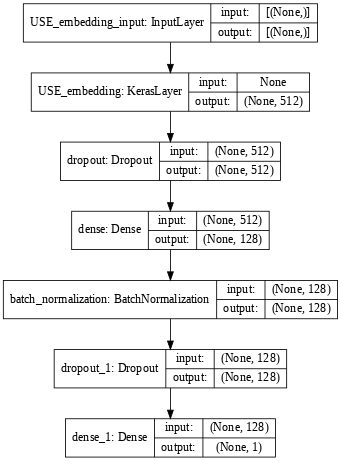

In [21]:
es = tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', 
          verbose=1, 
          patience=5, 
          mode='min', 
          restore_best_weights=True
          )

mcb = tf.keras.callbacks.ModelCheckpoint (
         filepath=model_checkpoint_path,
         save_weights_only=True,
         monitor='val_loss',
         mode='min',
         verbose=1,
         save_best_only=True
        )

METRICS = [
             keras.metrics.TruePositives(name='tp'),
             keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'),
             keras.metrics.FalseNegatives(name='fn'), 
             keras.metrics.BinaryAccuracy(name='accuracy'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc'),
             keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw'
      )

classifier_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
    )

tf.keras.utils.plot_model(model=classifier_model, show_shapes=True, dpi=60)

###Train

In [24]:
#@title Load Model weights if available
if os.path.exists(checkpoint_root_path) & len(os.listdir(checkpoint_root_path))>0:
  print('loading saved weight')
  classifier_model.load_weights(model_checkpoint_path)
else:
  print('No weight to initialize') 

No weight to initialize


In [25]:
history = classifier_model.fit(
             x=train_ds,
             validation_data=val_ds,
             epochs=epochs,
             callbacks=[es, mcb]
             )

Epoch 1/15
608/608 [==============================] - 155s 210ms/step - loss: 0.1935 - tp: 17489.0000 - fp: 1583.0000 - tn: 18196.0000 - fn: 1644.0000 - accuracy: 0.9171 - precision: 0.9170 - recall: 0.9141 - auc: 0.9771 - prc: 0.9774 - val_loss: 0.0868 - val_tp: 3880.0000 - val_fp: 151.0000 - val_tn: 4051.0000 - val_fn: 110.0000 - val_accuracy: 0.9681 - val_precision: 0.9625 - val_recall: 0.9724 - val_auc: 0.9952 - val_prc: 0.9946

Epoch 00001: val_loss improved from inf to 0.08683, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints/youtube_clickbait_finetuned_USE_all/youtube_clickbait_finetuned_USE_all_checkpoint
Epoch 2/15
608/608 [==============================] - 124s 204ms/step - loss: 0.0468 - tp: 18815.0000 - fp: 319.0000 - tn: 19460.0000 - fn: 318.0000 - accuracy: 0.9836 - precision: 0.9833 - recall: 0.9834 - auc: 0.9982 - prc: 0.9978 - val_loss: 0.1208 - val_tp: 3789.0000 - val_fp: 53.0000 - val_tn: 4149.0000 - val

In [ ]:
# Save model weights
classifier_model.save_weights(model_checkpoint_path)

#Plot train history

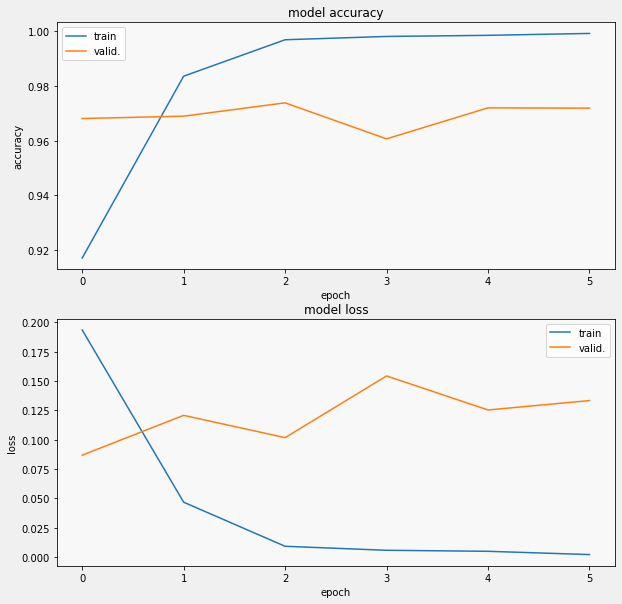

In [26]:
vh.display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

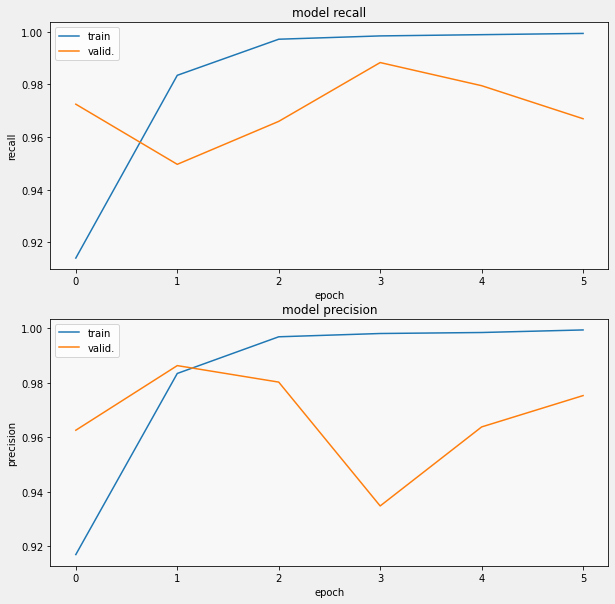

In [27]:
vh.display_training_curves(history.history['recall'], history.history['val_recall'], 'recall', 211)
vh.display_training_curves(history.history['precision'], history.history['val_precision'], 'precision', 212)

# Model Inference
We have trained the classifier, now let's use the trained model to infer the test dataset. Beside the test dataset, we also have benchmark dataset that we would also to see the eefectiveness of our model over benchmark dataset on predicting the clickbait's.

##Model Evaluation

###Evaluate Classifier on Test set

In [28]:
results_test_set = classifier_model.evaluate(test_ds)

for name, value in zip(classifier_model.metrics_names, results_test_set):
  print(name, ': ', value)
print()

30/30 [==============================] - 2s 60ms/step - loss: 0.0776 - tp: 874.0000 - fp: 34.0000 - tn: 989.0000 - fn: 23.0000 - accuracy: 0.9703 - precision: 0.9626 - recall: 0.9744 - auc: 0.9963 - prc: 0.9960
loss :  0.0776376873254776
tp :  874.0
fp :  34.0
tn :  989.0
fn :  23.0
accuracy :  0.9703124761581421
precision :  0.9625550508499146
recall :  0.9743589758872986
auc :  0.9963083267211914
prc :  0.9959926605224609



### Evaluate Classifier on Benchmarking set

In [29]:
results_benchmarking_set = classifier_model.evaluate(benchmark_ds)

for name, value in zip(classifier_model.metrics_names, results_benchmarking_set):
  print(name, ': ', value)
print()

2/2 [==============================] - 1s 479ms/step - loss: 0.5793 - tp: 45.0000 - fp: 1.0000 - tn: 52.0000 - fn: 30.0000 - accuracy: 0.7578 - precision: 0.9783 - recall: 0.6000 - auc: 0.8867 - prc: 0.9278
loss :  0.5792939066886902
tp :  45.0
fp :  1.0
tn :  52.0
fn :  30.0
accuracy :  0.7578125
precision :  0.97826087474823
recall :  0.6000000238418579
auc :  0.8866665959358215
prc :  0.9278291463851929



##Export Model for inference

In [34]:
classifier_model.save(saved_model_path, include_optimizer=False)

##Model prediction

In [35]:
saved_classifier = keras.models.load_model(saved_model_path)

### Prediction for Test set

Accuracy: 0.970313
Precision: 0.962555
Recall: 0.974359
F1 score: 0.968421
ROC AUC: 0.970562
[[989  34]
 [ 23 874]]
Non clickbaits Detected (True Negatives):  989
Non-Clickbaits Detected as Clickbaits (False Positives):  34
Clickbaits Detected as Non-clickbaits (False Negatives):  23
Clickbaits Detected (True Positives):  874
Total Non-clickbaits:  1023
Total Clickbaits:  897



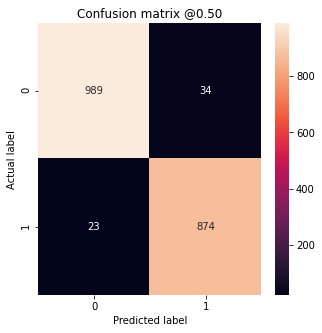

In [36]:
predict_on_test_dataset(saved_classifier, test_ds, BATCH_SIZE=BATCH_SIZE)

### Prediction for Benchmarking set

Accuracy: 0.757812
Precision: 0.978261
Recall: 0.600000
F1 score: 0.743802
ROC AUC: 0.790566
[[52  1]
 [30 45]]
Non clickbaits Detected (True Negatives):  52
Non-Clickbaits Detected as Clickbaits (False Positives):  1
Clickbaits Detected as Non-clickbaits (False Negatives):  30
Clickbaits Detected (True Positives):  45
Total Non-clickbaits:  53
Total Clickbaits:  75



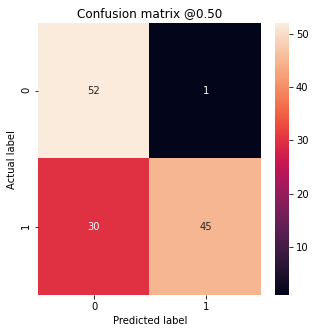

In [37]:
predict_on_test_dataset(saved_classifier, benchmark_ds, BATCH_SIZE=BATCH_SIZE)